## Import Libraries

In [1]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

## Load the Data

In [2]:
final_data = pd.read_csv('final_data.csv')

In [3]:
final_data.shape

(10754, 22)

In [4]:
final_data.head(2)

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,/david-de-gea/profil/spieler/59377,Manchester United,David de Gea,Goalkeeper,189.0,32.0,104,0.0,0.0,0.009585,...,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,/jack-butland/profil/spieler/128899,Manchester United,Jack Butland,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,...,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [5]:
# uniqeness
final_data.drop_duplicates(inplace=True)
final_data[final_data.duplicated()]

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger


In [6]:
# Completeness
final_data.isnull().sum()

player                 0
team                   0
name                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
position_encoded       0
winger                 0
dtype: int64

In [7]:
# Accurecy types
final_data.dtypes

player                  object
team                    object
name                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
position_encoded         int64
winger                   int64
dtype: object

In [8]:
# Accurecy - Outlier

# Convert categorical variables using OneHotEncoding
numeric_features = ['height', 'age', 'appearance', 'goals', 'assists', 'yellow cards', 'second yellow cards', 'red cards', 'goals conceded', 'clean sheets', 'minutes played', 'days_injured', 'games_injured', 'award', 'current_value', 'highest_value', 'position_encoded', 'winger']


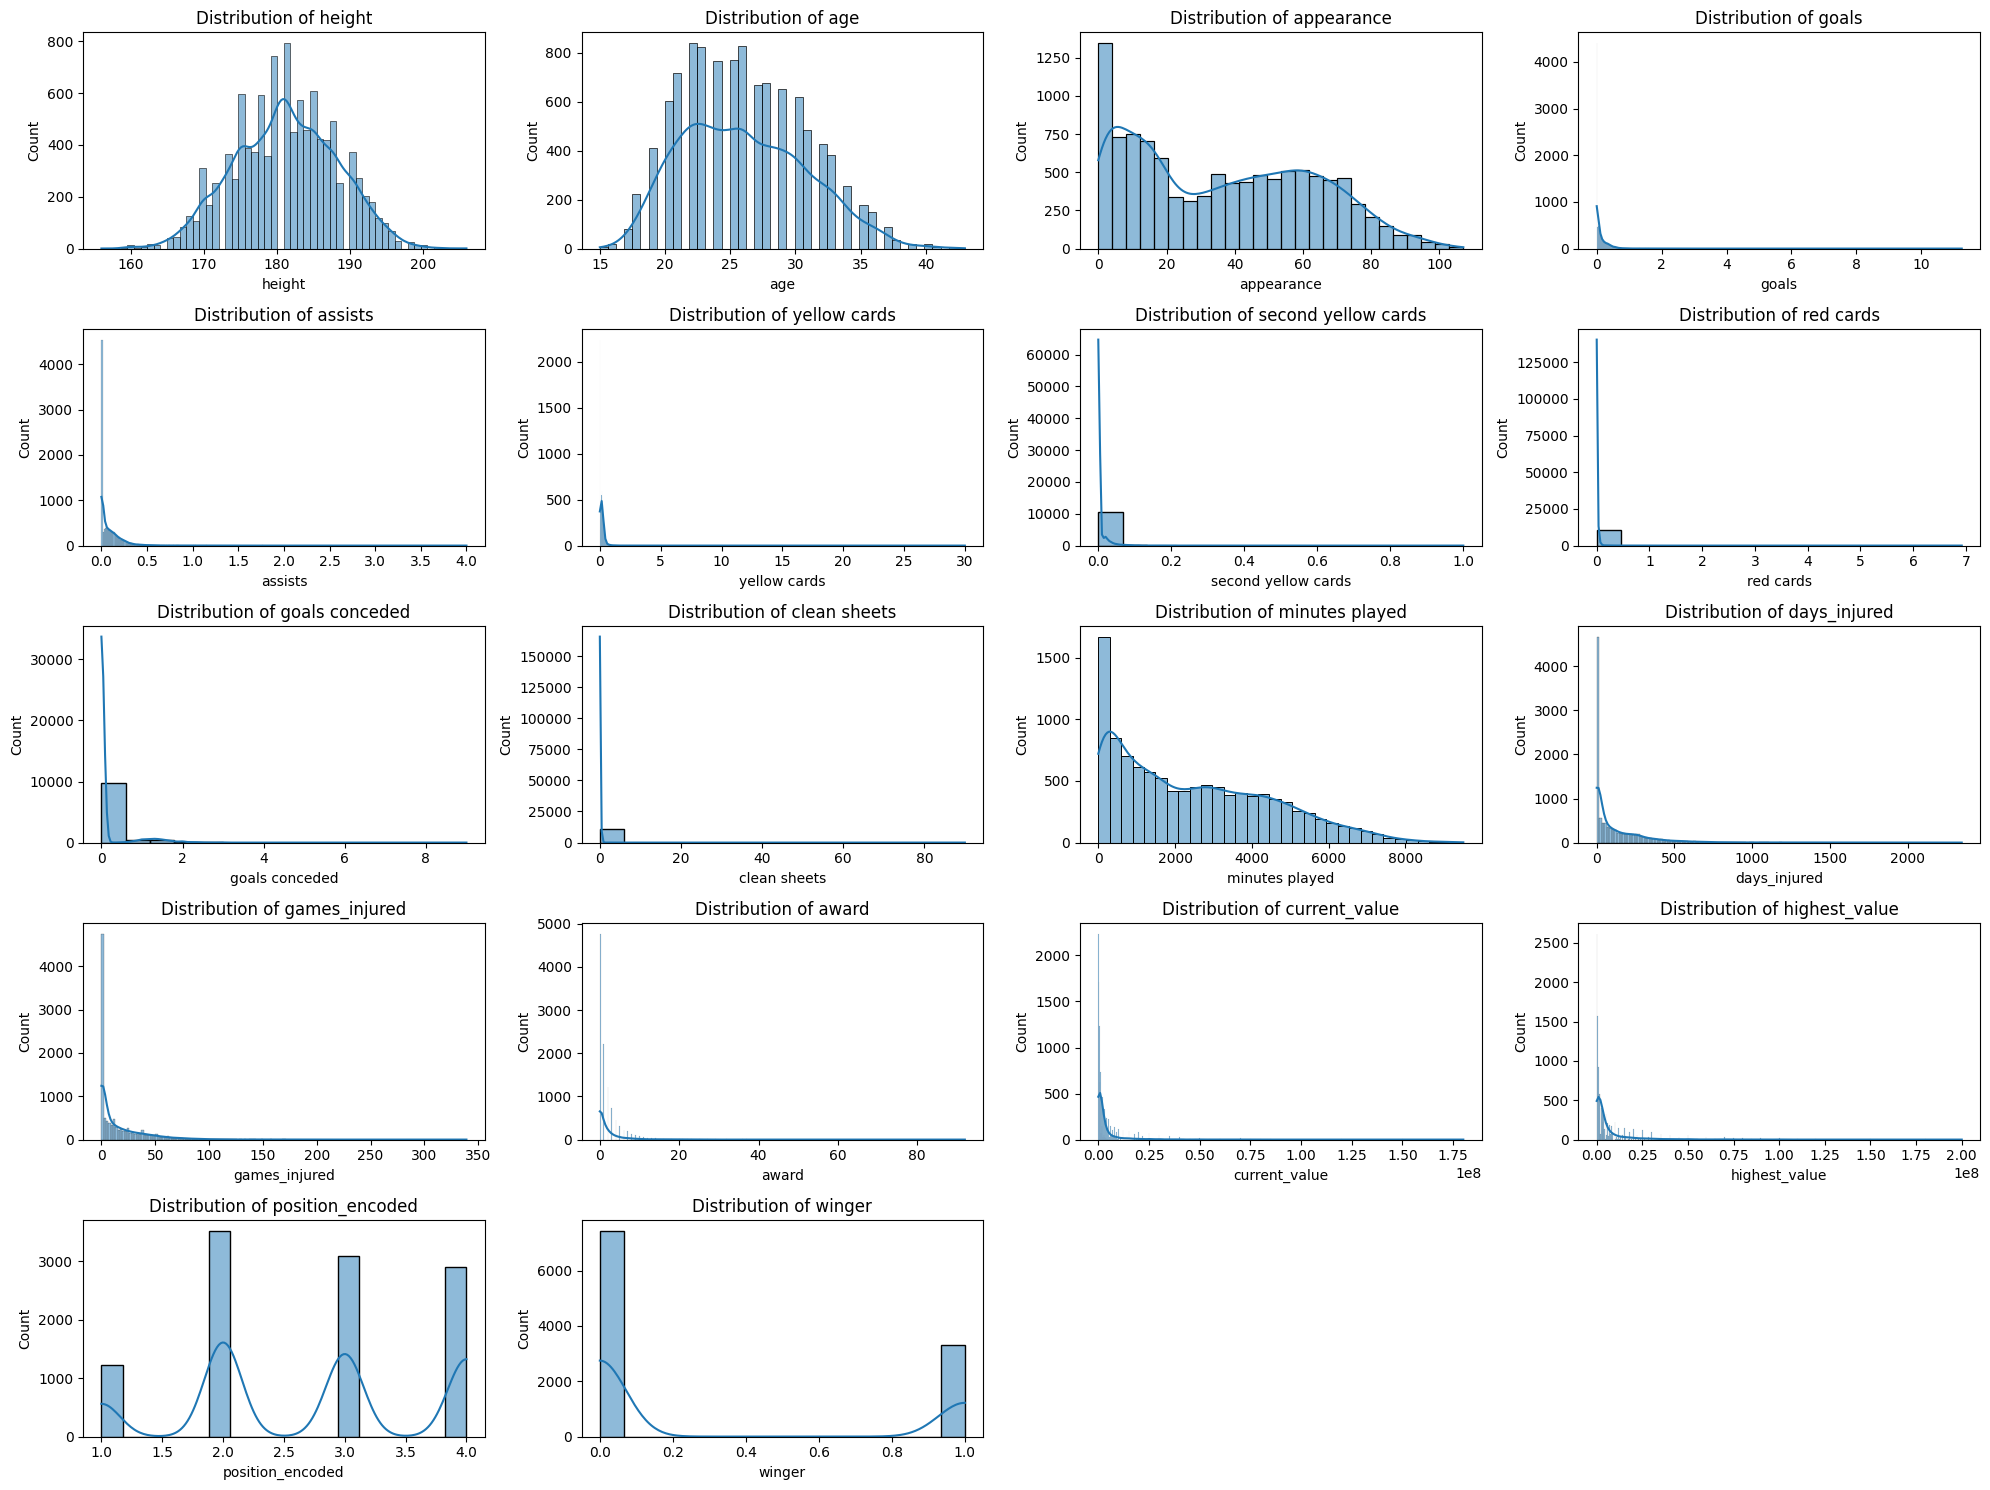

In [9]:
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numeric_features):
    plt.subplot(5, 4, i+1)
    sns.histplot(final_data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

In [10]:
categorical_features = ['team', 'name', 'position']
df = pd.get_dummies(final_data, columns=categorical_features, drop_first=True)

In [11]:
for i in categorical_features:
    print (final_data[i].value_counts())

team
Daejeon Hana Citizen      46
Jeonbuk Hyundai Motors    46
FC Seoul                  45
Gangwon FC                43
Daegu FC                  42
                          ..
FC Barcelona              22
Atlético de Madrid        22
CA Osasuna                22
Hatayspor                 12
Gaziantep FK               6
Name: count, Length: 374, dtype: int64
name
Paulinho              6
Vitinho               5
Guilherme             5
Fernando              4
João Pedro            4
                     ..
Everson               1
Matheus Mendes        1
Gabriel Delfim        1
Nathan Silva          1
Alexander Badolato    1
Name: count, Length: 10584, dtype: int64
position
Defender Centre-Back          1821
Attack Centre-Forward         1353
Goalkeeper                    1229
midfield-CentralMidfield      1149
midfield-DefensiveMidfield     900
Defender Right-Back            867
Defender Left-Back             807
midfield-AttackingMidfield     769
Attack-RightWinger             717
Att

In [12]:
award_counts = final_data.groupby('name')['award'].sum().sort_values(ascending=False)

top_10_names = award_counts.head(10)

name_with_highest_award = top_10_names.idxmax()
highest_award_count = top_10_names.max()

fig = px.bar(top_10_names, x=top_10_names.values, y=top_10_names.index, orientation='h', 
             labels={'x': 'Award Count', 'index': 'Name'}, title='Top 10 Names Based on Award Counts')

fig.add_shape(type="line", x0=0, x1=highest_award_count, y0=name_with_highest_award, 
              y1=name_with_highest_award, line=dict(color="Red", width=3), xref='x', yref='y')

fig.add_annotation(x=highest_award_count, y=name_with_highest_award, 
                   text=f'Highest Award Count: {highest_award_count}', 
                   showarrow=True, arrowhead=2, ax=20, ay=-30)

fig.update_layout(yaxis={'categoryorder':'total ascending'})

fig.show()

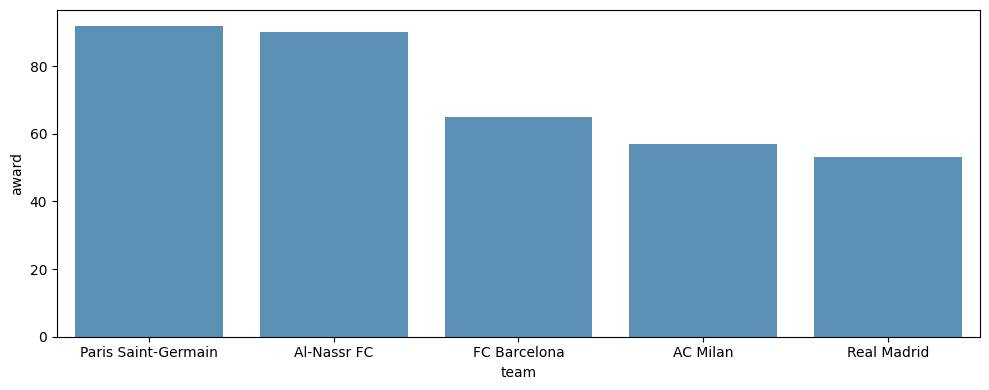

In [13]:
top_teams = final_data.nlargest(5, 'award')

plt.figure(figsize=(10, 4))
sns.barplot(data=top_teams, x='team', y='award', alpha=0.8)
plt.tight_layout()
plt.show()

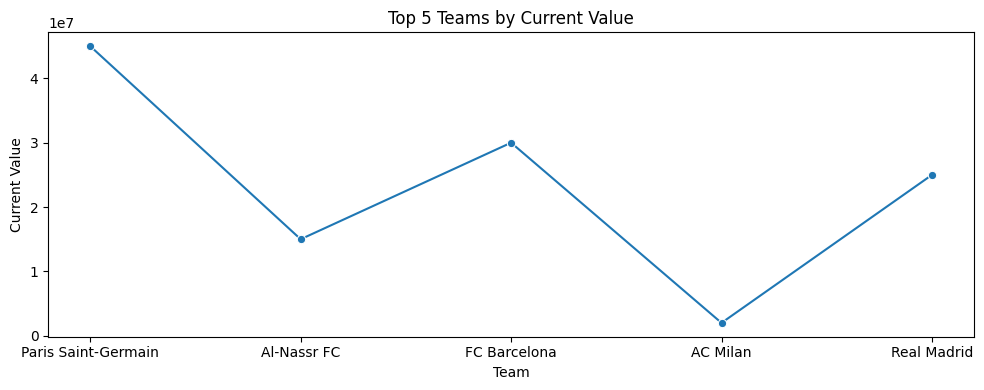

In [14]:
plt.figure(figsize=(10, 4))
sns.lineplot(data=top_teams, x='team', y='current_value', marker='o')
plt.title('Top 5 Teams by Current Value')
plt.xlabel('Team')
plt.ylabel('Current Value')
plt.tight_layout()
plt.show()

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [15]:
final_data.head(2)

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,/david-de-gea/profil/spieler/59377,Manchester United,David de Gea,Goalkeeper,189.0,32.0,104,0.0,0.0,0.009585,...,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,/jack-butland/profil/spieler/128899,Manchester United,Jack Butland,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,...,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0


#### 3. Feature selection

In [16]:
categorical_features

['team', 'name', 'position']

In [17]:
final_data = pd.get_dummies(final_data, columns=categorical_features)

In [18]:
numeric_features = final_data.select_dtypes(include=['float64', 'int64']).columns
categorical_features = final_data.select_dtypes(exclude=['float64', 'int64']).columns

In [19]:
p35 = final_data['current_value'].quantile(0.35)
p75 = final_data['current_value'].quantile(0.75)

def categorize_price(price):
    if price < p35:
        return 'Cheap_Price'
    elif price < p75:
        return 'Good_Price'
    else:
        return 'High_Price'

final_data['price_category'] = final_data['current_value'].apply(categorize_price)

final_data.drop('current_value', axis=1, inplace=True)

print(final_data['price_category'].value_counts())

price_category
Good_Price     4310
Cheap_Price    3754
High_Price     2690
Name: count, dtype: int64


In [20]:
p35, p75

(450000.0, 3000000.0)

In [21]:
encoder = LabelEncoder()
final_data['price_category_encoded'] = encoder.fit_transform(final_data['price_category'])  

In [22]:
correlation = final_data.corr(numeric_only=True)
print(correlation['price_category_encoded'].sort_values(ascending=False))

price_category_encoded    1.000000
appearance                0.546979
minutes played            0.519476
highest_value             0.488265
award                     0.242359
                            ...   
team_Royal AM FC         -0.067733
position_Attack          -0.082597
position_midfield        -0.096901
goals conceded           -0.128555
position_Goalkeeper      -0.172988
Name: price_category_encoded, Length: 10992, dtype: float64


In [23]:
# Set the correlation threshold
threshold = 0.2  

selected_features = correlation[abs(correlation['price_category_encoded']) > \
threshold]['price_category_encoded'].index
selected_features

Index(['appearance', 'minutes played', 'games_injured', 'award',
       'highest_value', 'price_category_encoded'],
      dtype='object')

In [24]:
final_data = final_data[selected_features]
final_data.head()

,appearance,minutes played,games_injured,award,highest_value,price_category_encoded
0,104,9390,5,13,70000000,2
1,15,1304,58,1,22000000,1
2,4,292,84,4,6000000,1
3,82,6408,22,9,50000000,2
4,63,5031,51,21,80000000,2


#### 4. Prepare train and test data

In [25]:
# Prepare data
X = final_data


# sacle the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [26]:
X.shape

(10754, 6)

## Buliding the Model

In [27]:
# 2. Use NearestNeighbors to find the optimal eps
min_samples = 2

In [28]:
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_scaled)
distances, indices = nn.kneighbors(X_scaled)

In [29]:
#indices

In [30]:
distances[:,min_samples-1]

array([1.20146228, 0.57576855, 0.32711393, ..., 0.00717247, 0.0170646 ,
       0.03777628])

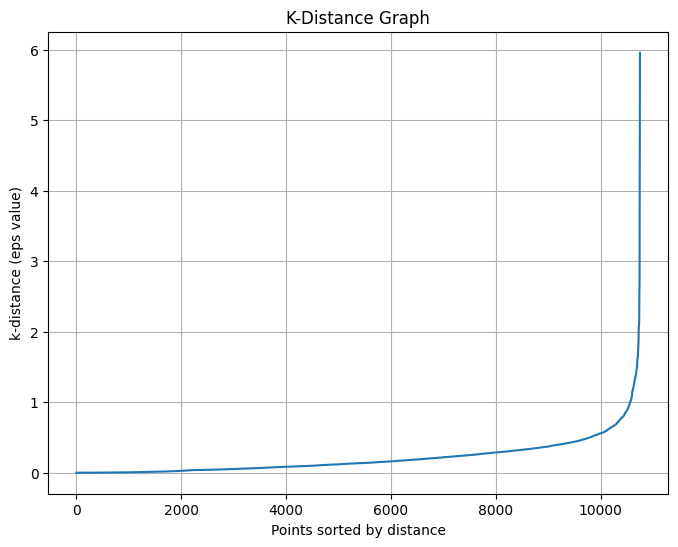

In [31]:
# The distance to the furthest neighbor (min_samples-th nearest) for each point
k_dist = distances[:, min_samples-1]

# Sort distances
k_dist_sorted = np.sort(k_dist)

# 3. Plotting the k-distance graph
plt.figure(figsize=(8, 6))
plt.plot(k_dist_sorted)
plt.title('K-Distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance (eps value)')
plt.grid(True)
plt.show()

In [32]:
# 4. Apply DBSCAN with chosen eps and min_samples
# Typically, you choose eps at the "elbow" point in this plot, where the slope changes significantly
chosen_eps = 0.3  # This is an example; choose this value based on the plot
dbscan = DBSCAN(eps=chosen_eps, min_samples=min_samples)

## Train the Model

In [33]:
# Fit the model on the training data

clusters = dbscan.fit_predict(X_scaled)

In [34]:
pd.Series(clusters).value_counts()

 8      3293
 0      3136
-1      2561
 2       770
 193      19
        ... 
 155       2
 160       2
 162       2
 163       2
 354       2
Name: count, Length: 356, dtype: int64

## Evaluating the Model 

In [35]:
silhouette_avg = silhouette_score(X, clusters)
silhouette_avg

-0.8070456209812997

In [36]:
X.head(2)

,appearance,minutes played,games_injured,award,highest_value,price_category_encoded
0,104,9390,5,13,70000000,2
1,15,1304,58,1,22000000,1


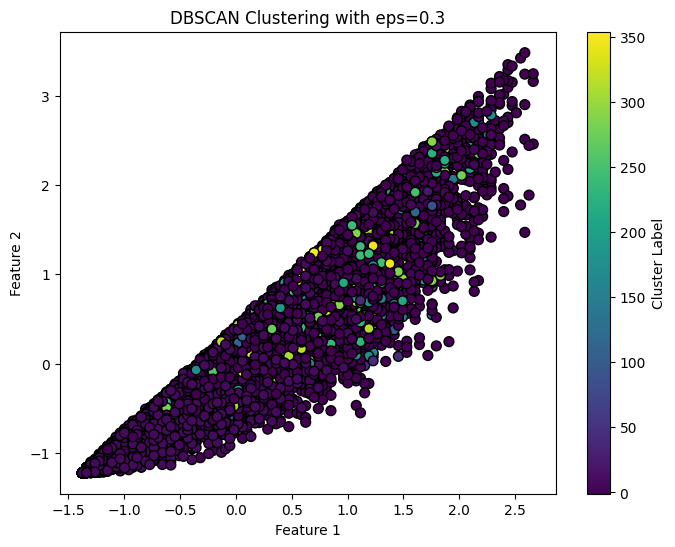

In [37]:
# 5. Plot the clustering result
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', s=50, edgecolor='k')
plt.title(f'DBSCAN Clustering with eps={chosen_eps}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [38]:
X['dbscan'] = clusters

In [39]:
X['dbscan'].value_counts()

dbscan
 8      3293
 0      3136
-1      2561
 2       770
 193      19
        ... 
 155       2
 160       2
 162       2
 163       2
 354       2
Name: count, Length: 356, dtype: int64

In [40]:
final_data.head(5)

,appearance,minutes played,games_injured,award,highest_value,price_category_encoded,dbscan
0,104,9390,5,13,70000000,2,-1
1,15,1304,58,1,22000000,1,-1
2,4,292,84,4,6000000,1,-1
3,82,6408,22,9,50000000,2,-1
4,63,5031,51,21,80000000,2,-1


<Axes: xlabel='minutes played', ylabel='award'>

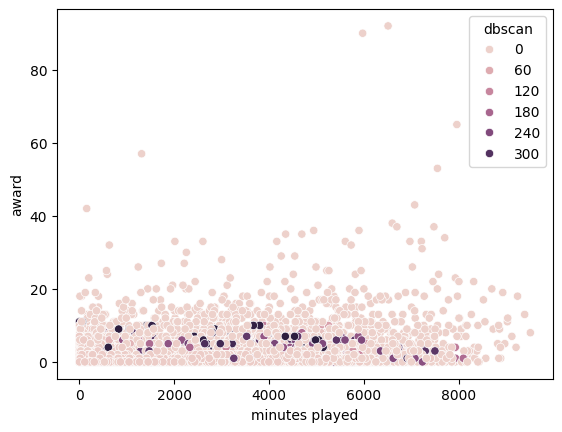

In [41]:
sns.scatterplot(data = X , x = 'minutes played', y = 'award', hue = 'dbscan')

In [42]:
sns.scatterplot(data = X , x = 'appearance', y = 'current_value', hue = 'dbscan')

ValueError: Could not interpret value `current_value` for `y`. An entry with this name does not appear in `data`.